#Importing the Necessary Libraries

In [ ]:
!pip uninstall -q -y tensorflow
!pip install -q tf-nightly
!pip install wandb -qq
import numpy as np
import io
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from IPython.display import clear_output
from IPython.display import display
import ipywidgets as widgets
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import urllib.request
clear_output()
content_image = None

#Select a Style Image

In [ ]:
STYLE_IMAGE_NAME = 'IMAGE_3' #@param ['IMAGE_1', 'IMAGE_2', 'IMAGE_3', 'IMAGE_4', 'IMAGE_5', 'IMAGE_6']

corresponding_url = {
    'IMAGE_1': 'https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg',
    'IMAGE_2': 'https://storage.googleapis.com/khanhlvg-public.appspot.com/arbitrary-style-transfer/style23.jpg',
    'IMAGE_3': 'https://upload.wikimedia.org/wikipedia/commons/thumb/a/a5/Tsunami_by_hokusai_19th_century.jpg/1024px-Tsunami_by_hokusai_19th_century.jpg',
    'IMAGE_4': 'https://upload.wikimedia.org/wikipedia/commons/thumb/c/c5/Edvard_Munch%2C_1893%2C_The_Scream%2C_oil%2C_tempera_and_pastel_on_cardboard%2C_91_x_73_cm%2C_National_Gallery_of_Norway.jpg/800px-Edvard_Munch%2C_1893%2C_The_Scream%2C_oil%2C_tempera_and_pastel_on_cardboard%2C_91_x_73_cm%2C_National_Gallery_of_Norway.jpg',
    'IMAGE_5': 'https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/757px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg',
    'IMAGE_6': 'https://upload.wikimedia.org/wikipedia/commons/thumb/4/4c/Vincent_van_Gogh_-_Self-Portrait_-_Google_Art_Project_%28454045%29.jpg/220px-Vincent_van_Gogh_-_Self-Portrait_-_Google_Art_Project_%28454045%29.jpg'
}

style_image_url = corresponding_url[STYLE_IMAGE_NAME]
style_image_path = STYLE_IMAGE_NAME + '.jpg'
urllib.request.urlretrieve(style_image_url, style_image_path)
print("Style Image Downloaded.")

Style Image Downloaded.


#Upload a Content Image

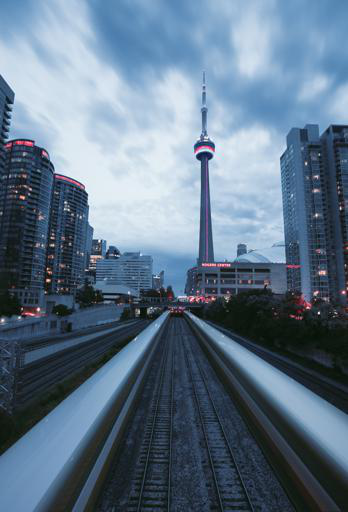

In [ ]:
def on_file_upload(change):
    global content_image
    image = Image.open(io.BytesIO(uploader.data[-1]))
    content_image = image
    image = image.convert('RGB')
    image.thumbnail((512, 512))
    image.save('content.jpg')
    image = Image.open('content.jpg')
    display(image)

uploader = widgets.FileUpload()
uploader.observe(on_file_upload, names='value')
display(widgets.VBox([widgets.Label('Upload a Content Image.'), uploader]))

# **Webcam**

In [ ]:
VIDEO_HTML = """
<video autoplay
 width=%d height=%d style='cursor: pointer;'></video>
<script>

var video = document.querySelector('video')

navigator.mediaDevices.getUserMedia({ video: true })
  .then(stream=> video.srcObject = stream)

var data = new Promise(resolve=>{
  video.onclick = ()=>{
    var canvas = document.createElement('canvas')
    var [w,h] = [video.offsetWidth, video.offsetHeight]
    canvas.width = w
    canvas.height = h
    canvas.getContext('2d')
          .drawImage(video, 0, 0, w, h)
    video.srcObject.getVideoTracks()[0].stop()
    video.replaceWith(canvas)
    resolve(canvas.toDataURL('image/jpeg', %f))
  }
})
</script>
"""
def take_photo(filename='photo.jpg', quality=0.8, size=(800,600)):
    global content_image
    display(HTML(VIDEO_HTML % (size[0],size[1],quality)))
    data = eval_js("data")
    binary = b64decode(data.split(',')[1])
    f = io.BytesIO(binary)
    content_image = Image.open(f)
    print('\nImage captured!')

take_photo()

#Load the Style Image

In [ ]:
def load_style_image(image_path):
  image = tf.io.read_file(image_path)
  image = tf.io.decode_image(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = image[tf.newaxis, :]

  return image

style_image = load_style_image(style_image_path)
print('Style Image loaded.')

Style Image loaded.


#Load the Content Image

In [ ]:
def load_content_image(content_image):
    if content_image.shape[-1] == 4:
        content_image = Image.fromarray(content_image)
        image = content_image.convert('RGB')
        image = np.array(image)
        image = tf.convert_to_tensor(image)
        image = tf.image.convert_image_dtype(image, tf.float32)
        image = image[tf.newaxis, :]
        return image
    elif content_image.shape[-1] == 3:
        image = tf.convert_to_tensor(content_image)
        image = tf.image.convert_image_dtype(image, tf.float32)
        image = image[tf.newaxis, :]
        return image
    elif content_image.shape[-1] == 1:
        raise Error('Grayscale images not supported.')

content_image = np.array(content_image)
content_image = load_content_image(content_image)

print('Content Image loaded.')

Content Image loaded.


#Image Preprocessing

In [ ]:
def preprocess_image(image, target_size):
  shape = tf.cast(tf.shape(image)[1:-1], tf.float32)
  shortest_dimension = min(shape)
  scale = target_size / shortest_dimension
  new_shape = tf.cast(shape * scale, tf.int32)
  image = tf.image.resize(image, new_shape)

  image = tf.image.resize_with_crop_or_pad(image, target_size, target_size)

  return image

#Convert Image

In [ ]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return Image.fromarray(tensor)

#Predict Style

In [ ]:
def style_predict(preprocessed_style_image):
    with open(style_prediction, 'rb') as f:
        tflite_model_content = f.read()
    interpreter = tf.lite.Interpreter(model_content=tflite_model_content)

    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()
    interpreter.set_tensor(input_details[0]['index'], preprocessed_style_image)
    interpreter.invoke()

    output_details = interpreter.get_output_details()
    style_bottleneck = interpreter.get_tensor(output_details[0]['index'])

    return style_bottleneck

#Style Transfer

In [ ]:
def style_transform(style_bottleneck, preprocessed_content_image):
  interpreter = tf.lite.Interpreter(model_path=style_transformation)
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()
  output_details = interpreter.get_output_details()

  input_shape = input_details[0]['shape']
  input_shape[0] = 1
  input_shape[1] = preprocessed_content_image.shape[1]
  input_shape[2] = preprocessed_content_image.shape[2]
  interpreter.resize_tensor_input(input_details[0]['index'], input_shape)
  interpreter.allocate_tensors()

  interpreter.set_tensor(input_details[0]['index'], preprocessed_content_image)
  interpreter.set_tensor(input_details[1]['index'], style_bottleneck)

  interpreter.invoke()

  stylized_image = interpreter.get_tensor(output_details[0]['index'])

  return stylized_image

#Download Model

In [ ]:
style_prediction = tf.keras.utils.get_file('style_predict.tflite', 'https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
style_transformation = tf.keras.utils.get_file('style_transform.tflite', 'https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')

print('Model Files Downloaded.')

Model Files Downloaded.


#Define Content Weight and Content Image Size

In [ ]:
content_weight = 0 #@param {type:"slider", min:0, max:1, step:0.01}

content_image_size = 512 #@param {type:"slider", min:256, max:512, step:1}

#Preprocess Content and Style image

In [ ]:
preprocessed_content_image = preprocess_image(content_image, content_image_size)
preprocessed_style_image = preprocess_image(style_image, 256)
print("Images Preprocessed.")

Images Preprocessed.


#Calculate Style Bottleneck

In [ ]:
style_bottleneck = style_predict(preprocessed_style_image)
style_bottleneck_content = style_predict(preprocess_image(content_image, 256))

style_bottleneck_blended = content_weight * (style_bottleneck_content - 2.5*style_bottleneck) + style_bottleneck

#Stylized Image

In [ ]:
stylized_image = style_transform(style_bottleneck_blended, preprocessed_content_image)

#Plot Content, Style, Stylized Image

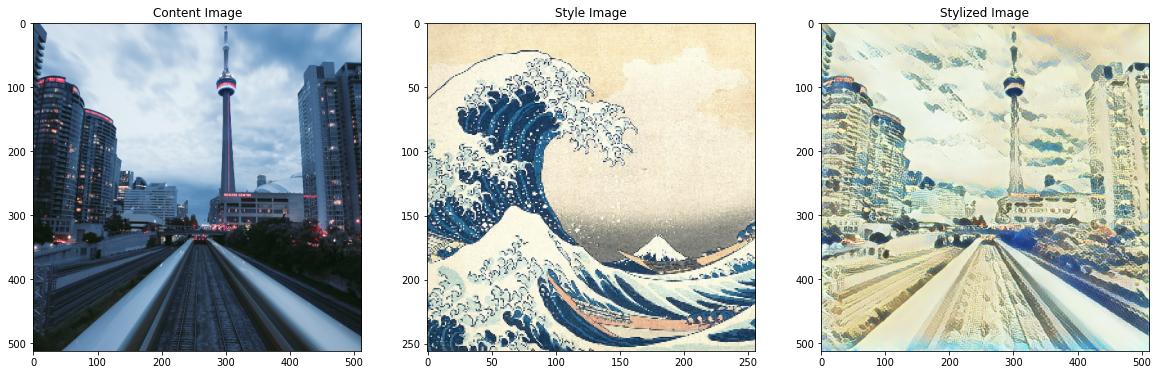

In [ ]:
def plot_images(images, titles=None):
  num_images = len(images)

  fig, axes = plt.subplots(1, num_images, figsize=(20, 20))

  for i, (image, ax) in enumerate(zip(images, axes)):
    if len(image.shape) > 3:
      image = tf.squeeze(image, axis=0)

    ax.imshow(image)

    if titles is not None and i < len(titles):
      ax.set_title(titles[i])

  plt.show()

plot_images([preprocessed_content_image, preprocessed_style_image, stylized_image], ['Content Image', 'Style Image', 'Stylized Image'])

#Save Stylized Image

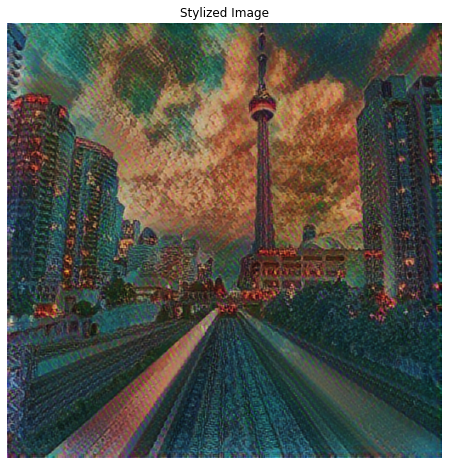

In [ ]:
nst_image = tensor_to_image(stylized_image)

plt.figure(figsize=(8, 8))
plt.imshow(nst_image)
plt.title("Stylized Image")
plt.axis("off")
plt.show()

nst_image.save('Style-transfer-image.jpeg')